In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 데이터 생성 함수
def generate_data(n_samples=1000):
    x = np.random.uniform(-10, 10, n_samples)
    x = np.sort(x)
    # 실제 2차 함수: y = 2x² + 3x + 1
    y = 2 * x**2 + 3 * x + 1
    return torch.FloatTensor(x).view(-1, 1), torch.FloatTensor(y).view(-1, 1)

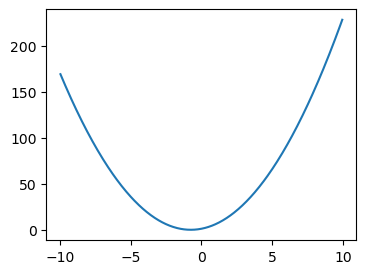

In [2]:
# 데이터 생성
x_train, y_train = generate_data()

plt.figure(figsize=(4, 3))
plt.plot(x_train.numpy(), y_train.numpy())
plt.show()

In [3]:
# 신경망 모델 정의
class QuadraticNet(nn.Module):
    def __init__(self):
        super(QuadraticNet, self).__init__()
        self.fc1 = nn.Linear(1, 64).cuda(0)
        self.fc2 = nn.Linear(64, 32).cuda(0)
        self.fc3 = nn.Linear(32, 1).cuda(1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = x.to(1)
        # x = self.fc1(x)
        # x = self.fc2(x)
        x = self.fc3(x)
        return x

### 메모리 체크

In [4]:
def count_gpu_memories(usage=""):
    num_gpus = torch.cuda.device_count()
    gpu_memory_info = []
    
    for i in range(num_gpus):
        allocated = torch.cuda.memory_allocated(i)
        gpu_memory_info.append(
            (i, allocated / 1024**2)  # MB 단위로 변환
        )
    
    print(f"{usage} GPU 메모리 사용량 (단위: MB):")
    for gpu_id, allocated_mb in gpu_memory_info:
        print(f"GPU {gpu_id} - Allocated: {allocated_mb:.4f} MB")

In [5]:
# 모델 초기화
count_gpu_memories("초기")

초기 GPU 메모리 사용량 (단위: MB):
GPU 0 - Allocated: 0.0000 MB
GPU 1 - Allocated: 0.0000 MB


In [6]:
# # 모델 초기화
# initial_memory = torch.cuda.memory_allocated()
# print(f"초기 GPU 메모리 사용량: {initial_memory / 1024**2:.4f} MB")
model = QuadraticNet()
count_gpu_memories("Model")

Model GPU 메모리 사용량 (단위: MB):
GPU 0 - Allocated: 0.0093 MB
GPU 1 - Allocated: 0.0010 MB


#### sample param, grad

In [7]:
sample_param = next(model.parameters())

In [8]:
epochs=100
lr=0.01
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

x_train = x_train.to(0)
y_train = y_train.to(1)
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    memory_start = torch.cuda.memory_allocated()
    outputs = model(x_train)
    if epoch==0:#<=1
        count_gpu_memories("Forward")
    loss = criterion(outputs, y_train)
    loss.backward()
    if epoch==0:#<=1
        count_gpu_memories("Backward")
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    losses.append(loss.item())

Forward GPU 메모리 사용량 (단위: MB):
GPU 0 - Allocated: 8.5044 MB
GPU 1 - Allocated: 8.2559 MB
Backward GPU 메모리 사용량 (단위: MB):
GPU 0 - Allocated: 16.2725 MB
GPU 1 - Allocated: 16.2637 MB
Epoch [100/10000], Loss: 357.2542
Epoch [200/10000], Loss: 59.2687
Epoch [300/10000], Loss: 12.7825
Epoch [400/10000], Loss: 3.3439
Epoch [500/10000], Loss: 1.1136
Epoch [600/10000], Loss: 0.4794
Epoch [700/10000], Loss: 0.2569
Epoch [800/10000], Loss: 0.1581
Epoch [900/10000], Loss: 0.1095
Epoch [1000/10000], Loss: 0.0836
Epoch [1100/10000], Loss: 0.0718
Epoch [1200/10000], Loss: 0.0555
Epoch [1300/10000], Loss: 0.0481
Epoch [1400/10000], Loss: 0.0449
Epoch [1500/10000], Loss: 0.1175
Epoch [1600/10000], Loss: 0.0380
Epoch [1700/10000], Loss: 0.0361
Epoch [1800/10000], Loss: 0.0440
Epoch [1900/10000], Loss: 0.0705
Epoch [2000/10000], Loss: 0.1742
Epoch [2100/10000], Loss: 0.0371
Epoch [2200/10000], Loss: 0.0639
Epoch [2300/10000], Loss: 0.0573
Epoch [2400/10000], Loss: 0.0867
Epoch [2500/10000], Loss: 0.1124
E

KeyboardInterrupt: 

In [ ]:
# 학습된 모델의 예측 예시
test_x = torch.FloatTensor([-3, -2, -1, 0, 1, 2, 3]).view(-1, 1).cuda()
exact_y = 2 * test_x**2 + 3 * test_x + 1
with torch.no_grad():
    test_y = model(test_x)
    plt.plot(test_x.cpu(), test_y.cpu(), label='pred')
    plt.plot(test_x.cpu(), exact_y.cpu(), label='exact')
    plt.legend()
    plt.show()
    print("\n테스트 예측 결과:")
    for x, y, y_answer in zip(test_x, test_y, exact_y):
        print(f"x = {x.item():.1f}, 예측값 = {y.item():.2f}, 실제값 = {y_answer.item():.2f}")